In [8]:
from CANCER import *
import matplotlib.pyplot as plt

"""
TODO - 1:
1. self edge, reverse edge, normal edge, self reverse edge testing
2. 1-column, one-hot column testing
3. hyperparameter tuning
TODO - 2:
1. path nn testing
"""

'\nTODO - 1:\n1. self edge, reverse edge, normal edge, self reverse edge testing\n2. 1-column, one-hot column testing\n3. hyperparameter tuning\nTODO - 2:\n1. path nn testing\n'

In [2]:
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv, GINEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
import torch.nn as nn


class GINCustomConv(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GINCustomConv, self).__init__()
        self.conv = GINConv(
            Sequential(
                Linear(dim_in, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_out),
                ReLU()
            ),
            train_eps=True
        )    
    def forward(self, X, edge_index):
        return self.conv(X, edge_index)
        

class GIN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, layer_num=3):
        super(GIN, self).__init__()
        assert layer_num >= 1
        self.layer_num = layer_num
        if layer_num == 1:
            self.conv_in = GINCustomConv(dim_in, dim_h, dim_h)
        elif layer_num >= 2:
            self.conv_in = GINCustomConv(dim_in, dim_h, dim_h)
            self.conv = nn.ModuleList([GINCustomConv(dim_h, dim_h, dim_h) for _ in range(layer_num-1)])
        
        self.lin1 = Linear(dim_h * layer_num, dim_h * layer_num)
        self.lin2 = Linear(dim_h * layer_num, dim_out)

    def __readout(self, embedded_layers, batch):
        embedded_list = []
        for h in embedded_layers:
            temp_read = global_add_pool(h, batch)
            embedded_list.append(temp_read)
        graph_embedded = torch.cat(embedded_list, dim=1)
        return graph_embedded

    def __classification(self, embedded):
        h = self.lin1(embedded)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        return h, F.log_softmax(h, dim=1)
 
    def __embedding(self, data):
        embedded_layers = []
        h = self.conv_in(data.x, data.edge_index)
        embedded_layers.append(h)
        for conv in self.conv:
            h = conv(h, data.edge_index)
            embedded_layers.append(h)
        return embedded_layers

    def forward(self, data):
        if self.layer_num == 1:
            h = self.conv_in(data.x, data.edge_index)
            h = global_add_pool(h, data.batch)
            return self.__classification(h)

        # Node embeddings
        embedded_layers = self.__embedding(data)
        graph_embedded = self.__readout(embedded_layers, data.batch)
        return self.__classification(graph_embedded)
 

In [47]:
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader

class Trainer:
    def __init__(self, epochs = 100, learning_rate = 0.01, weight_decay=0.01, eps = 1e-5, print_every=10, device='cpu'):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.eps = eps
        self.print_every = print_every
        self.device = device

    def train(self, model, dataset, debug = False, batch_size = 32, train_rate=0.7, val_rate=0.2, test_rate=0.1):
        train_data, validation_data, test_data = self.__split_dataset(dataset, train_rate, val_rate, test_rate)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        model = model.to(self.device)        
        
        if debug:
            torch.autograd.set_detect_anomaly(True)
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr = self.learning_rate, 
            weight_decay=self.weight_decay, 
            eps=self.eps
        )
        criterion = torch.nn.CrossEntropyLoss()

        train_losses = []
        train_acc = []
        val_losses = []
        val_accs = []

        for epoch in range(self.epochs + 1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0
            for data in train_loader:
                model.train()
                data = data.to(self.device)
                optimizer.zero_grad()
                _, out = model(data)
                loss = criterion(out, data.y)
                total_loss += loss / len(train_loader)
                acc += self.accuracy(out.argmax(dim=1), data.y) / len(train_loader)
                loss.backward()
                optimizer.step()

                val_loss, val_acc = self.test(model, val_loader, device=self.device)

            train_losses.append(total_loss)
            train_acc.append(acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            if epoch % self.print_every == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
                        f'| Train Acc: {acc*100:>5.2f}% '
                        f'| Val Loss: {val_loss:.5f} '
                        f'| Val Acc: {val_acc*100:.5f}%')
        test_loss, test_acc = self.test(model, test_loader, device=self.device)
        print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
            
        history = {'train_loss': train_losses, 'train_acc': train_acc, 'val_loss': val_losses, 'val_acc': val_accs}
        return history, model
        
    @torch.no_grad()
    def test(self, model, loader, device='cpu'):
        criterion = torch.nn.CrossEntropyLoss()
        model.eval()
        loss = 0
        acc = 0

        for data in loader:
            data.to(device)
            _, out = model(data)
            loss += criterion(out, data.y) / len(loader)
            acc += self.accuracy(out.argmax(dim=1), data.y) / len(loader)
        return loss, acc

    def accuracy(self, pred_y, y):
        """Calculate accuracy."""
        return ((pred_y == y).sum() / len(y)).item()
    
    
    def __split_dataset(self, dataset, train_rate = 0.7, val_rate = 0.2, test_rate = 0.1):
        dataset_len = len(dataset)
        grouped_data = {}
        
        data_train = []
        data_validation = []
        data_test = []

        for i in range(dataset_len):
            data = dataset[i]
            if data.y.item() not in grouped_data:
                grouped_data[data.y.item()] = [data]
            else:
                grouped_data[data.y.item()].append(data)

        for group, data in grouped_data.items():
            train_data_group = data[:int(len(data)*train_rate)]
            validation_data_group = data[int(len(data)*train_rate):int(len(data)*(train_rate+val_rate))]
            test_data_group = data[int(len(data)*(train_rate+val_rate)):]            
        
            data_train.extend(train_data_group)
            data_validation.extend(validation_data_group)
            data_test.extend(test_data_group)

        return data_train, data_validation, data_test

trainer = Trainer(device='cuda')

In [49]:
def show_history(history):
    for idx in range(len(history['train_loss'])):
        if type(history['train_loss'][idx]) == torch.Tensor:
            history['train_loss'][idx] = history['train_loss'][idx].cpu().item()
        if type(history['val_loss'][idx]) == torch.Tensor:
            history['val_loss'][idx] = history['val_loss'][idx].cpu().item()
        if type(history['train_acc'][idx]) == torch.Tensor:
            history['train_acc'][idx] = history['train_acc'][idx].cpu().item()
        if type(history['val_acc'][idx]) == torch.Tensor:
            history['val_acc'][idx] = history['val_acc'][idx].cpu().item()

    plt.plot(history['train_loss'], label='train loss', color='red')
    plt.plot(history['val_loss'], label='validation loss', color='blue')
    # plt.plot(history['train_acc'], label='train accuracy', color='green')
    # plt.plot(history['val_acc'], label='validation accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('loss')

In [15]:
brac = MyDataSet(
                [NLabel.BRAC_TCGA.filename, NLabel.BRAC_TCGA_PAN_CAN_ATLAS.filename, NLabel.BRAC_TCGA_PUB2015.filename], 
                [ELabel.BREAST_CANCER],
                drop_y_threshold=1,
                reverse = False,
                self_edge = False
            )

brac_rev = MyDataSet(
                [NLabel.BRAC_TCGA.filename, NLabel.BRAC_TCGA_PAN_CAN_ATLAS.filename, NLabel.BRAC_TCGA_PUB2015.filename], 
                [ELabel.BREAST_CANCER],
                drop_y_threshold=1,
                reverse = True,
                self_edge = False
            )
brac_self = MyDataSet(
                [NLabel.BRAC_TCGA.filename, NLabel.BRAC_TCGA_PAN_CAN_ATLAS.filename, NLabel.BRAC_TCGA_PUB2015.filename], 
                [ELabel.BREAST_CANCER],
                drop_y_threshold=1,
                reverse = False,
                self_edge = True
            )
brac_rev_self = MyDataSet(
                [NLabel.BRAC_TCGA.filename, NLabel.BRAC_TCGA_PAN_CAN_ATLAS.filename, NLabel.BRAC_TCGA_PUB2015.filename], 
                [ELabel.BREAST_CANCER],
                drop_y_threshold=1,
                reverse = True,
                self_edge = True
            )

yset  15
yset  15
yset  15
yset  15


In [16]:
brac_dataset = brac.make_dataset()
brac_dataset_onehot = brac.make_dataset_onehot_column()

brac_rev_dataset = brac_rev.make_dataset()
brac_rev_dataset_onehot = brac_rev.make_dataset_onehot_column()

brac_self_dataset = brac_self.make_dataset()
brac_self_dataset_onehot = brac_self.make_dataset_onehot_column()

brac_rev_self_dataset = brac_rev_self.make_dataset()
brac_rev_self_dataset_onehot = brac_rev_self.make_dataset_onehot_column()


Epoch   0 | Train Loss: 1.93 | Train Acc: 65.47% | Val Loss: 1.06842 | Val Acc: 69.79950%
Epoch  10 | Train Loss: 1.04 | Train Acc: 69.29% | Val Loss: 0.99443 | Val Acc: 69.71335%
Epoch  20 | Train Loss: 1.05 | Train Acc: 69.32% | Val Loss: 0.99007 | Val Acc: 69.62719%
Epoch  30 | Train Loss: 1.04 | Train Acc: 69.65% | Val Loss: 1.00589 | Val Acc: 69.36873%
Epoch  40 | Train Loss: 1.05 | Train Acc: 69.38% | Val Loss: 0.99596 | Val Acc: 69.62719%
Epoch  50 | Train Loss: 1.04 | Train Acc: 69.73% | Val Loss: 0.98956 | Val Acc: 69.79950%
Epoch  60 | Train Loss: 1.04 | Train Acc: 69.67% | Val Loss: 1.02692 | Val Acc: 69.88565%
Epoch  70 | Train Loss: 1.04 | Train Acc: 69.67% | Val Loss: 0.99708 | Val Acc: 69.45489%
Epoch  80 | Train Loss: 1.04 | Train Acc: 69.48% | Val Loss: 1.00430 | Val Acc: 69.62719%
Epoch  90 | Train Loss: 1.07 | Train Acc: 69.65% | Val Loss: 1.05358 | Val Acc: 69.62719%
Epoch 100 | Train Loss: 1.06 | Train Acc: 69.57% | Val Loss: 1.02087 | Val Acc: 70.14411%
Test Loss:

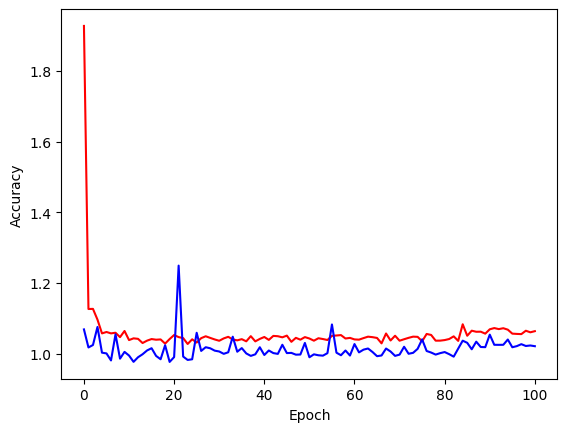

In [48]:
# gin_32_layer1 = GIN(
#                     brac_dataset.num_node_features, 
#                     32, 
#                     brac_dataset.num_classes, 1
#                 )
# gin_32_layer2 = GIN(
#                     brac_dataset.num_node_features,
#                     32,
#                     brac_dataset.num_classes, 2
# )
gin_32_layer3_normal_normal = GIN( brac_dataset.num_node_features, 32, brac_dataset.num_classes, 3)
history, _ = trainer.train(gin_32_layer3_normal_normal, brac_dataset)
show_history(history)
